In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
import spacy as sp

nlp = sp.load('en_core_web_sm')

## Import data

In [3]:
data = pd.read_csv('CVEs_merged_clean_clustered.csv')
data

,CVE ID,Publish Date,Update Date,Number Of Related Vulnerabilities,CWE ID,Vulnerability Type(s),Score,Access,Complexity,Authentication,Conf.,Integ.,Avail,CVE Summary,Vulnerability Name,Vulnerability Description,index,index_clustermap,cluster
0,CVE-2019-1020019,2019-07-29,2019-07-31,22413.0,79,XSS,4.3,Remote,Medium,Not required,NaN,Partial,NaN,invenio-previewer before 1.0.0a12 allows XSS.,Failure to Preserve Web Page Structure ('Cross...,The software does not sufficiently valida...,1,1,0
1,CVE-2019-1020018,2019-07-29,2022-04-18,3011.0,287,Unknown,7.5,Remote,Low,Not required,Partial,Partial,Partial,Discourse before 2.3.0 and 2.4.x before 2.4.0....,Improper Authentication,When an actor claims to have a given iden...,2,2,2
2,CVE-2019-1020016,2019-07-29,2019-08-01,754.0,601,Unknown,5.8,Remote,Medium,Not required,Partial,Partial,NaN,ASH-AIO before 2.0.0.3 allows an open redirect.,URL Redirection to Untrusted Site ('Open Redir...,A web application accepts a user-controll...,3,3,0
3,CVE-2019-1020015,2019-07-29,2021-07-21,9380.0,20,Unknown,5.0,Remote,Low,Not required,NaN,Partial,NaN,graphql-engine (aka Hasura GraphQL Engine) bef...,Improper Input Validation,The product does not validate or incorrec...,4,4,0
4,CVE-2019-1020014,2019-07-29,2022-10-06,394.0,415,Unknown,2.1,Local,Low,Not required,Partial,NaN,NaN,docker-credential-helpers before 0.6.3 has a d...,Double Free,The product calls free() twice on the sam...,5,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61693,CVE-2008-10001,2022-03-28,2022-04-08,22413.0,79,XSS,4.3,Remote,Medium,Not required,NaN,Partial,NaN,** UNSUPPORTED WHEN ASSIGNED ** A vulnerabilit...,Failure to Preserve Web Page Structure ('Cross...,The software does not sufficiently valida...,61694,61694,0
61694,CVE-2007-20001,2022-02-06,2022-09-01,1320.0,400,DoS,5.0,Remote,Low,Not required,NaN,NaN,Partial,A flaw was found in StarWind iSCSI target. An ...,Uncontrolled Resource Consumption ('Resource E...,The software does not properly restrict t...,61695,61695,0
61695,CVE-2005-10001,2022-03-28,2022-04-08,754.0,601,Unknown,5.8,Remote,Medium,Not required,Partial,Partial,NaN,** UNSUPPORTED WHEN ASSIGNED ** A vulnerabilit...,URL Redirection to Untrusted Site ('Open Redir...,A web application accepts a user-controll...,61696,61696,0
61696,CVE-2003-5003,2022-03-28,2022-04-06,22413.0,79,XSS,4.3,Remote,Medium,Not required,NaN,Partial,NaN,** UNSUPPORTED WHEN ASSIGNED ** A vulnerabilit...,Failure to Preserve Web Page Structure ('Cross...,The software does not sufficiently valida...,61697,61697,0


In [4]:
data.shape

(61698, 19)

In [5]:
for col in data.columns:
    print(data[col].nunique(),'\t',col)

61698 	 CVE ID
1347 	 Publish Date
1306 	 Update Date
122 	 Number Of Related Vulnerabilities
261 	 CWE ID
136 	 Vulnerability Type(s)
62 	 Score
4 	 Access
4 	 Complexity
3 	 Authentication
3 	 Conf.
3 	 Integ.
3 	 Avail
58934 	 CVE Summary
261 	 Vulnerability Name
261 	 Vulnerability Description
61698 	 index
61698 	 index_clustermap
3 	 cluster


## Combine Text cols

In [6]:
textual_cols = ['CWE ID','index', 'Vulnerability Name', 'Vulnerability Description', 'CVE Summary','cluster']
df_text = data[textual_cols]
df_text.head(2)

,CWE ID,index,Vulnerability Name,Vulnerability Description,CVE Summary,cluster
0,79,1,Failure to Preserve Web Page Structure ('Cross...,The software does not sufficiently valida...,invenio-previewer before 1.0.0a12 allows XSS.,0
1,287,2,Improper Authentication,When an actor claims to have a given iden...,Discourse before 2.3.0 and 2.4.x before 2.4.0....,2


In [7]:
# Add Text column
df_text['Text'] = df_text['Vulnerability Name'] + df_text['Vulnerability Description'] + df_text['CVE Summary']
df_text.head(2)

,CWE ID,index,Vulnerability Name,Vulnerability Description,CVE Summary,cluster,Text
0,79,1,Failure to Preserve Web Page Structure ('Cross...,The software does not sufficiently valida...,invenio-previewer before 1.0.0a12 allows XSS.,0,Failure to Preserve Web Page Structure ('Cross...
1,287,2,Improper Authentication,When an actor claims to have a given iden...,Discourse before 2.3.0 and 2.4.x before 2.4.0....,2,Improper Authentication When an actor clai...


## Text Processing
- tokenization and remove : stopwords,spaces,punctuation,bracket,quote,digits and lemmatization

In [8]:

def tokenize_text(text): 
    text = nlp(text)
    tokens = []
    for token in text:
        if not token.is_stop and not token.is_space and not token.is_punct and not token.is_bracket \
        and not token.is_quote and token.is_alpha: #remove digits
            tokens.append(token.lemma_.lower())
    return tokens


## Chunks
-  chunksize parameter that can be used to read larger than the memory datasets

In [9]:

def chunks(csv_input_name, input_column, output_column, csv_output_name, func, chunksize=10000):
    i = 1
    df = pd.DataFrame()
    for reader in pd.read_csv(csv_input_name, chunksize=chunksize):
        reader[output_column] = reader[input_column].apply(func)
        print('chunk',i,'\n ',reader,'\n=============================\n')
        df = pd.concat([df,reader] , ignore_index=True)
        i = i+1
    return df.to_csv(csv_output_name , index=False)

# chunks('df_text.csv','Text','NLP','all_chunks.csv' , func=tokenize_text , chunksize=10000)

## Cleaning 

In [10]:
all_chunks = pd.read_csv('all_chunks.csv')
all_chunks.head(2)

,CWE ID,index,Vulnerability Name,Vulnerability Description,CVE Summary,cluster,Text,NLP,CLEAN TEXT,cluster_2
0,79,1,Failure to Preserve Web Page Structure ('Cross...,The software does not sufficiently valida...,invenio-previewer before 1.0.0a12 allows XSS.,0,Failure to Preserve Web Page Structure ('Cross...,"['failure', 'preserve', 'web', 'page', 'struct...",failure preserve web page structure cross site...,1
1,287,2,Improper Authentication,When an actor claims to have a given iden...,Discourse before 2.3.0 and 2.4.x before 2.4.0....,2,Improper Authentication When an actor clai...,"['improper', 'authentication', 'actor', 'claim...",improper authentication actor claim give ident...,2


In [11]:
all_chunks['NLP'][1]

"['improper', 'authentication', 'actor', 'claim', 'give', 'identity', 'software', 'prove', 'insufficiently', 'prove', 'claim', 'correct', 'discourse', 'lack', 'confirmation', 'screen', 'log', 'email', 'link']"

In [11]:

def remove_quotes(text):
    pattern = r'[:,"\[\],\']'
    cleaned_string = re.sub(pattern, "", text)
    return cleaned_string

# all_chunks['CLEAN TEXT'] = all_chunks['NLP'].apply(remove_quotes)
# all_chunks.to_csv('all_chunks.csv',index=False)

In [12]:
all_chunks['CLEAN TEXT'][1]

'improper authentication actor claim give identity software prove insufficiently prove claim correct discourse lack confirmation screen log email link'

## Vectorization

In [13]:

def sent_to_vec(text): 
    docc = nlp(text)
    vectors = []
    for s in docc.sents:
        vectors.append(s.vector)
    return vectors

def sent_to_vectors(text):
    docc = nlp(text)
    return docc.vector

# docc = nlp((all_chunks['CLEAN TEXT'][1]))
# print(docc.vector.shape, '\n', docc.text, '\n', docc.vector)

# chunks('all_chunks.csv','CLEAN TEXT','VECTORS','all_chunks_vectors.csv' , func = sent_to_vectors , chunksize=10000)

#### test lagre model

In [14]:
# !python -m spacy download en_core_web_lg # (587.7 MB)

nlp_lg = sp.load('en_core_web_lg')

def sent_to_vectors_lg(text):
    docc = nlp_lg(text)
    return docc.vector


In [15]:
lg = all_chunks.sample(10)
lg['VECTORS'] = lg['CLEAN TEXT'].apply(sent_to_vectors_lg)
lg
lg['VECTORS'].values[0].shape
# pd.DataFrame(lg['VECTORS'].values)

(300,)

#### test small model

In [16]:
spml = all_chunks.sample(10)
spml['VECTORS'] = spml['CLEAN TEXT'].apply(sent_to_vectors)
spml
spml['VECTORS'].values
# spml.to_csv('a.csv',index=False) 
pd.DataFrame(spml['VECTORS'].values)
spml['VECTORS'].values[0].shape
# dont save data to csv it will lost the np array

(96,)

#### vectorization

In [17]:
# %time
# all_chunks_vectors = pd.read_csv('all_chunks_vectors.csv')
# all_chunks_vectors.head(3)

# all_chunks_vectors_2 = all_chunks_vectors.copy()
# all_chunks_vectors_2['VECTORS_'] = all_chunks_vectors_2['CLEAN TEXT'].apply(sent_to_vectors) # take a while (40 min)

# all_chunks_vectors_2['VECTORS_'].values
# array_vectors = all_chunks_vectors_2['VECTORS_'].values
# df_vector = pd.DataFrame(array_vectors ,columns = ['VECTORS_'])
# df_vector

# df_vectors.to_pickle('b.pkl')
# pd.read_pickle('b.pkl')

In [18]:
# df_vector.to_pickle('vectors.pkl')
vectors = pd.read_pickle('vectors.pkl')
vectors

,VECTORS_
0,"[0.12703624, -0.8192423, 0.25019082, -0.119033..."
1,"[0.19605117, -0.8583198, 0.026019238, 0.022733..."
2,"[0.02975793, -0.86988807, 0.10869311, 0.032304..."
3,"[-0.007890648, -0.68850625, 0.14481676, -0.064..."
4,"[0.30467427, -0.75652087, -0.033255175, 0.0844..."
...,...
61693,"[0.1383172, -0.76037383, 0.23121478, -0.027008..."
61694,"[0.00014150691, -0.68129027, 0.12016464, -0.19..."
61695,"[0.08127529, -0.8288253, 0.13004833, 0.0688143..."
61696,"[0.11008966, -0.7826346, 0.22154608, -0.031635..."


#### Final 

In [19]:
sel = ['CWE ID','index','cluster','CLEAN TEXT']
processed_text_df = pd.concat([all_chunks[sel] , vectors] , axis=1)
processed_text_df.head()

,CWE ID,index,cluster,CLEAN TEXT,VECTORS_
0,79,1,0,failure preserve web page structure cross site...,"[0.12703624, -0.8192423, 0.25019082, -0.119033..."
1,287,2,2,improper authentication actor claim give ident...,"[0.19605117, -0.8583198, 0.026019238, 0.022733..."
2,601,3,0,url redirection untrusted site open redirect w...,"[0.02975793, -0.86988807, 0.10869311, 0.032304..."
3,20,4,0,improper input validation product validate inc...,"[-0.007890648, -0.68850625, 0.14481676, -0.064..."
4,415,5,0,double free product call free twice memory add...,"[0.30467427, -0.75652087, -0.033255175, 0.0844..."


## Clustering

In [20]:
vecs = np.stack(np.array(vectors).reshape(-1))
pd.DataFrame(vecs).describe()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
count,61698.000000,61698.000000,61698.000000,61698.000000,61698.000000,61698.000000,61698.000000,61698.000000,61698.000000,61698.000000,...,61698.000000,61698.000000,61698.000000,61698.000000,61698.000000,61698.000000,61698.000000,61698.000000,61698.000000,61698.000000
mean,0.035594,-0.727321,0.098550,0.010928,-0.151932,-0.036744,0.425116,0.650723,0.191459,-0.095628,...,-0.007261,-0.364713,-0.949536,0.367397,0.020139,0.279693,0.978499,0.781010,-0.288391,-0.000811
std,0.073666,0.103213,0.111004,0.091322,0.096345,0.062370,0.079233,0.172368,0.087276,0.112143,...,0.081645,0.118817,0.101349,0.129837,0.108874,0.126546,0.113334,0.071106,0.093121,0.098476
min,-0.340922,-1.142361,-0.388523,-0.339327,-0.453750,-0.461519,-0.137783,-0.020807,-0.243321,-0.673369,...,-0.501809,-0.771822,-1.305688,-0.228665,-0.355381,-0.310648,0.500889,0.276496,-0.717663,-0.427138
25%,-0.015007,-0.802402,0.017025,-0.059280,-0.222231,-0.069282,0.378271,0.526409,0.144005,-0.166371,...,-0.053703,-0.460948,-1.026764,0.285741,-0.059436,0.193158,0.893897,0.741549,-0.344787,-0.056884
50%,0.040153,-0.731273,0.110763,0.010538,-0.166007,-0.039882,0.420535,0.626229,0.194347,-0.086737,...,-0.014618,-0.371171,-0.960471,0.372404,0.025257,0.250392,0.973392,0.780662,-0.277753,-0.010905
75%,0.090002,-0.651878,0.188391,0.070737,-0.097758,-0.009668,0.469887,0.783037,0.237045,-0.014291,...,0.040811,-0.276171,-0.885666,0.452017,0.099821,0.363873,1.063717,0.819039,-0.231203,0.057667
max,0.378432,-0.131071,0.814618,0.542463,0.412752,0.288387,0.897571,1.235281,0.674880,0.521658,...,0.518008,0.485426,-0.298515,1.360768,0.837654,0.666460,1.478108,1.187473,0.362133,0.442215


In [31]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
vecs_scaled = scaler.fit_transform(vecs)
pd.DataFrame(vecs_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
count,61698.000000,61698.000000,61698.000000,61698.000000,61698.000000,61698.000000,61698.000000,61698.000000,61698.000000,61698.000000,...,61698.000000,61698.000000,61698.000000,61698.000000,61698.000000,61698.000000,61698.000000,61698.000000,61698.000000,61698.000000
mean,0.523409,0.410407,0.404835,0.397209,0.348318,0.566438,0.543678,0.534620,0.473513,0.483454,...,0.484938,0.323809,0.353615,0.375016,0.314761,0.604171,0.488744,0.553816,0.397549,0.490396
std,0.102406,0.102061,0.092262,0.103564,0.111188,0.083171,0.076527,0.137226,0.095051,0.093842,...,0.080058,0.094505,0.100627,0.081688,0.091258,0.129511,0.115976,0.078055,0.086240,0.113274
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.453066,0.336164,0.337074,0.317589,0.267188,0.523049,0.498432,0.435651,0.421831,0.424256,...,0.439398,0.247265,0.276937,0.323641,0.248060,0.515609,0.402170,0.510500,0.345321,0.425895
50%,0.529747,0.406499,0.414986,0.396767,0.332075,0.562254,0.539253,0.515120,0.476659,0.490895,...,0.477724,0.318673,0.342758,0.378166,0.319050,0.574183,0.483518,0.553434,0.407401,0.478784
75%,0.599043,0.485007,0.479507,0.465036,0.410838,0.602543,0.586920,0.639958,0.523160,0.551517,...,0.532076,0.394235,0.417030,0.428254,0.381549,0.690323,0.575948,0.595561,0.450511,0.557661
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


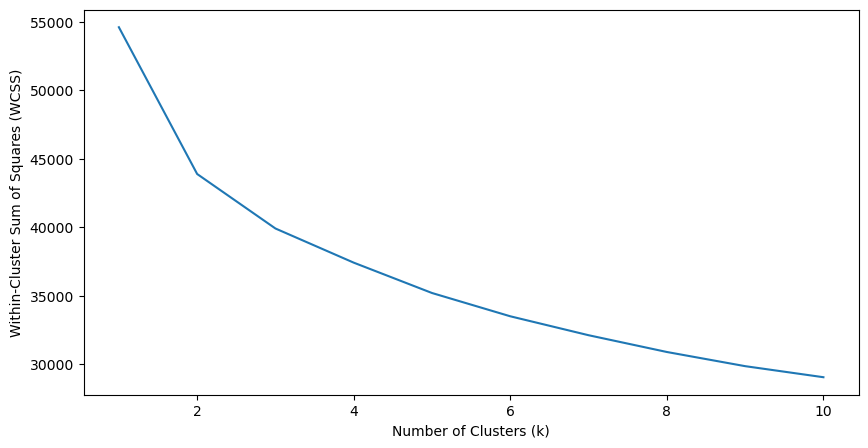

In [22]:
from sklearn.cluster import KMeans

loss = []
for k in range(1,11):
    kmeans_test = KMeans(n_clusters=k).fit(vecs_scaled)
    loss.append(kmeans_test.inertia_) #wcss

plt.figure(figsize=(10,5))
plt.plot(range(1,11) , loss)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()
# when WCSS starts to decrease at a slower rate
# without scaling k=2 , minmax k=2 , standard k=2 .

In [28]:
# type(vecs) , type(vecs_scaled)

In [38]:
from sklearn.cluster import KMeans


# fit the preprocessed data
k = 3
kmeans = KMeans(n_clusters=k, random_state=99)
kmeans_clusters = kmeans.fit_predict(vecs)

In [39]:
np.unique(kmeans.labels_)

array([0, 1, 2])

In [45]:
cluster_map = pd.DataFrame()
# cluster_map['index_clustermap'] = range(1,len(vecs)+1)
cluster_map['Kmeans_clusters'] = kmeans.labels_
cluster_map

,Kmeans_clusters
0,1
1,2
2,0
3,0
4,2
...,...
61693,1
61694,1
61695,0
61696,1


In [46]:
clustered_data = pd.concat([all_chunks , cluster_map] , axis=1)
clustered_data.head()

# print(clustered_data["cluster_2"].value_counts())
# sn.countplot(clustered_data["cluster_2"])

,CWE ID,index,Vulnerability Name,Vulnerability Description,CVE Summary,cluster,Text,NLP,CLEAN TEXT,cluster_2,Kmeans_clusters
0,79,1,Failure to Preserve Web Page Structure ('Cross...,The software does not sufficiently valida...,invenio-previewer before 1.0.0a12 allows XSS.,0,Failure to Preserve Web Page Structure ('Cross...,"['failure', 'preserve', 'web', 'page', 'struct...",failure preserve web page structure cross site...,1,1
1,287,2,Improper Authentication,When an actor claims to have a given iden...,Discourse before 2.3.0 and 2.4.x before 2.4.0....,2,Improper Authentication When an actor clai...,"['improper', 'authentication', 'actor', 'claim...",improper authentication actor claim give ident...,2,2
2,601,3,URL Redirection to Untrusted Site ('Open Redir...,A web application accepts a user-controll...,ASH-AIO before 2.0.0.3 allows an open redirect.,0,URL Redirection to Untrusted Site ('Open Redir...,"['url', 'redirection', 'untrusted', 'site', 'o...",url redirection untrusted site open redirect w...,0,0
3,20,4,Improper Input Validation,The product does not validate or incorrec...,graphql-engine (aka Hasura GraphQL Engine) bef...,0,Improper Input Validation The product does...,"['improper', 'input', 'validation', 'product',...",improper input validation product validate inc...,0,0
4,415,5,Double Free,The product calls free() twice on the sam...,docker-credential-helpers before 0.6.3 has a d...,0,Double Free The product calls free() twice...,"['double', 'free', 'product', 'call', 'free', ...",double free product call free twice memory add...,2,2


In [36]:
# clustered_data.to_csv('all_chunks.csv',index=False)

#### Plot clusters

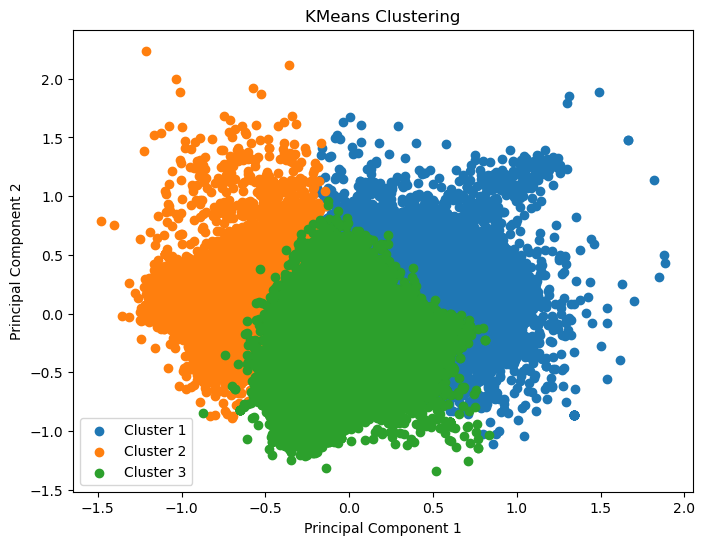

In [42]:
from sklearn.decomposition import PCA

# numpy_array = vecs
# kmeans = KMeans(n_clusters=n_clusters)
# clusters = kmeans.fit_predict(numpy_array)

n_clusters = 3
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(vecs)

# Plotting the clusters
plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    plt.scatter(reduced_data[kmeans_clusters == i, 0], reduced_data[kmeans_clusters == i, 1], label=f'Cluster {i+1}')

plt.title('KMeans Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


In [62]:
dataa = pd.read_csv('full_data_clustered_ssim.csv')
dataa = dataa.replace(np.nan,'None')

cols = ['index','Vulnerability Type(s)','Vulnerability Name','Access','Complexity','Authentication','Conf.','Integ.','Avail'
       ,'Score','Number Of Related Vulnerabilities','CI SCORE']

clustered_data = pd.concat([dataa[cols] , cluster_map['Kmeans_clusters']] , axis=1)
clustered_data

,index,Vulnerability Type(s),Vulnerability Name,Access,Complexity,Authentication,Conf.,Integ.,Avail,Score,Number Of Related Vulnerabilities,CI SCORE,Kmeans_clusters
0,1,XSS,Failure to Preserve Web Page Structure ('Cross...,Remote,Medium,Not required,None,Partial,None,4.3,22413.0,0.666677,1
1,2,Unknown,Improper Authentication,Remote,Low,Not required,Partial,Partial,Partial,7.5,3011.0,0.625171,2
2,3,Unknown,URL Redirection to Untrusted Site ('Open Redir...,Remote,Medium,Not required,Partial,Partial,None,5.8,754.0,0.636100,0
3,4,Unknown,Improper Input Validation,Remote,Low,Not required,None,Partial,None,5.0,9380.0,0.719175,0
4,5,Unknown,Double Free,Local,Low,Not required,Partial,None,None,2.1,394.0,0.707726,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61693,61694,XSS,Failure to Preserve Web Page Structure ('Cross...,Remote,Medium,Not required,None,Partial,None,4.3,22413.0,0.706891,1
61694,61695,DoS,Uncontrolled Resource Consumption ('Resource E...,Remote,Low,Not required,None,None,Partial,5.0,1320.0,0.789261,1
61695,61696,Unknown,URL Redirection to Untrusted Site ('Open Redir...,Remote,Medium,Not required,Partial,Partial,None,5.8,754.0,0.696738,0
61696,61697,XSS,Failure to Preserve Web Page Structure ('Cross...,Remote,Medium,Not required,None,Partial,None,4.3,22413.0,0.711290,1


In [60]:
print(clustered_data["Kmeans_clusters"].value_counts())

Kmeans_clusters
2    24046
0    22769
1    14883
Name: count, dtype: int64


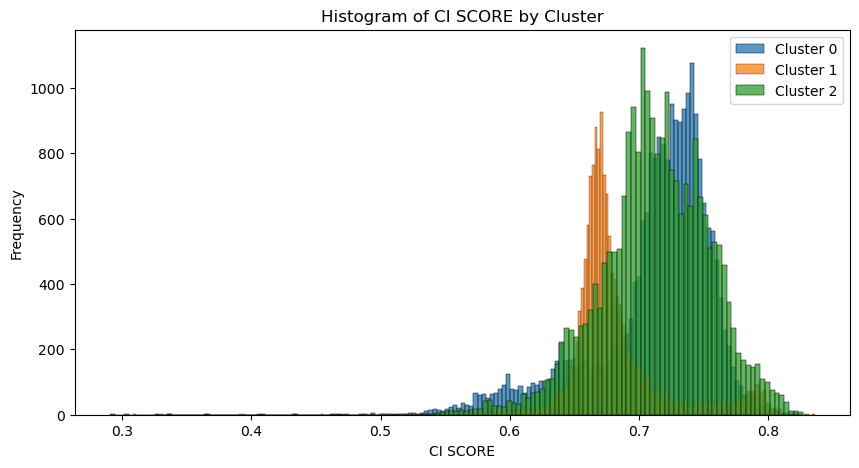

In [63]:
# Distribution for each cluster
cluster_0 = clustered_data[clustered_data['Kmeans_clusters']==0]
cluster_0_scores = cluster_0['CI SCORE']
cluster_1 = clustered_data[clustered_data['Kmeans_clusters']==1]
cluster_1_scores = cluster_1['CI SCORE']
cluster_2 = clustered_data[clustered_data['Kmeans_clusters']==2]
cluster_2_scores = cluster_2['CI SCORE']

plt.figure(figsize=(10,5))

# colors = ['blue', 'green', 'red']

# Plot histogram for each cluster with custom color
sn.histplot(cluster_0_scores, label='Cluster 0')
sn.histplot(cluster_1_scores, label='Cluster 1')
sn.histplot(cluster_2_scores, label='Cluster 2')

plt.title('Histogram of CI SCORE by Cluster')
plt.xlabel('CI SCORE')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#### Cluster by similarity with critical infrastructure

In [23]:
s1 = all_chunks['CLEAN TEXT'][1]
s2 = 'critical infrastructure'

doc1 = nlp(s1)
doc2 = nlp(s2)

doc1.similarity(doc2) # Make a semantic similarity estimate. 

0.42953072988705027

In [28]:

def simmm(text):
    docc = nlp(text)
    ci = nlp('critical infrastructure')
    return docc.similarity(ci)

sim = all_chunks.sample(10)
sim['SIM'] = sim['CLEAN TEXT'].apply(simmm)
sim
# sim['VECTORS'].values
# pd.DataFrame(sim['VECTORS'].values)

,CWE ID,index,Vulnerability Name,Vulnerability Description,CVE Summary,cluster,Text,NLP,CLEAN TEXT,SIM
6713,94,6714,Failure to Control Generation of Code ('Code I...,The product does not sufficiently filter ...,"In Modicon Quantum all firmware versions, a CW...",2,Failure to Control Generation of Code ('Code I...,"['failure', 'control', 'generation', 'code', '...",failure control generation code code injection...,0.474207
58419,59,58420,Improper Link Resolution Before File Access ('...,The software attempts to access a file ba...,A link following denial-of-service vulnerabili...,2,Improper Link Resolution Before File Access ('...,"['improper', 'link', 'resolution', 'file', 'ac...",improper link resolution file access link foll...,0.533445
28106,787,28107,Out-of-bounds Write,"The software writes data past the end, or...",Adobe Premiere Rush version 1.5.16 (and earlie...,2,Out-of-bounds Write The software writes da...,"['bound', 'write', 'software', 'write', 'datum...",bound write software write datum past end begi...,0.552138
9867,78,9868,Improper Sanitization of Special Elements used...,The software constructs all or part of an...,"A command injection (missing input validation,...",2,Improper Sanitization of Special Elements used...,"['improper', 'sanitization', 'special', 'eleme...",improper sanitization special elements os comm...,0.559351
59577,20,59578,Improper Input Validation,The product does not validate or incorrec...,Pexip Infinity before 26 allows temporary remo...,0,Improper Input Validation The product does...,"['improper', 'input', 'validation', 'product',...",improper input validation product validate inc...,0.596446
9981,732,9982,Incorrect Permission Assignment for Critical R...,The software specifies permissions for a ...,A File Write can occur for specially crafted P...,2,Incorrect Permission Assignment for Critical R...,"['incorrect', 'permission', 'assignment', 'cri...",incorrect permission assignment critical resou...,0.526881
54498,532,54499,Information Leak Through Log Files,Information written to log files can be o...,An insertion of sensitive information into log...,1,Information Leak Through Log Files Informa...,"['information', 'leak', 'log', 'files', 'infor...",information leak log files information write l...,0.543273
11928,416,11929,Use After Free,Referencing memory after it has been free...,While processing camera buffers in camera driv...,2,Use After Free Referencing memory after it...,"['use', 'free', 'referencing', 'memory', 'free...",use free referencing memory free cause program...,0.501887
25631,79,25632,Failure to Preserve Web Page Structure ('Cross...,The software does not sufficiently valida...,The BlueMail application through 1.9.5.36 for ...,0,Failure to Preserve Web Page Structure ('Cross...,"['failure', 'preserve', 'web', 'page', 'struct...",failure preserve web page structure cross site...,0.476360
18354,77,18355,Improper Sanitization of Special Elements used...,The software constructs all or part of a ...,Command Injection in EntoneWebEngine in Amino ...,2,Improper Sanitization of Special Elements used...,"['improper', 'sanitization', 'special', 'eleme...",improper sanitization special elements command...,0.545289
